# CRBP - Patient-Specific Verification Problem Session
### 25th November 2019 
### Sam Ingram - samuel.ingram@postgrad.manchester.ac.uk

## Introduction

In this session we will cover routine troubleshooting in patient-specific verifications. As this Quality Check (QC) is used as a key step in the treatment planning work-flow it is important to understand the test and what the results signify to us. Below is an example of the treatment planning work-flow and where the patient-specific verification is located. As you can see it takes place towards the end and helps to **ensure us that the treatment that we plan to deliver can *actually* be delivered on the machine.** 

<img src="image.png">

## Understanding the test
In order to understand some of the problems we can have in patient-specific verification, it is best to have a good understanding of the metrics we use to evaluate verifications. This section will try to visually explain the concept of the **Gamma Analysis** so that we can better discuss troubleshooting problems we see in clinical verifications...

In [1]:
# Let us set-up the requirements for the notebook before we start. Press shift+enter to run cells.
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import math
%matplotlib inline

### Let's talk about Gamma Analysis:
Let us solidify our understanding of the Gamma Analysis first, we will do this by simplifying the problem to 1D:

In [2]:
reference = [2.10, 2.12, 2.13, 2.12, 2.15]
measured = [2.09, 2.10, 2.15, 2.15, 2.20]

In 1D we can represent our *reference dose* (obtained from the treatment planning system (TPS)) and *measured dose* (obtained from our measurement device or secondary TPS) as simple arrays. Where, each value in the array represents dose and position in the array corresponds to 1mm shifts in position. The object of a Gamma Analysis is to set a threshold which balances both dose deviation and distance-to-agreement to conduct a treatment plan verification.

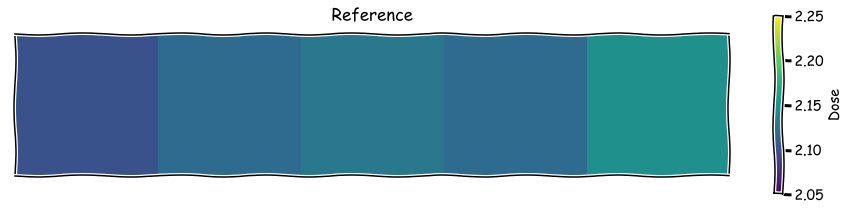

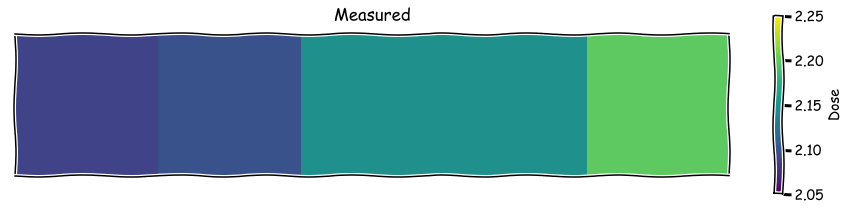

In [3]:
plot_ref = []
plot_meas = []
plot_ref.append(reference)
plot_meas.append(measured)
with plt.xkcd():  # Save the neat plots for the research papers!
    plt.matshow(plot_ref, vmin=2.05, vmax=2.25);
    plt.yticks([]);
    plt.xticks([]);
    plt.colorbar(label='Dose');
    plt.title("Reference");
    plt.matshow(plot_meas, vmin=2.05, vmax=2.25);
    plt.yticks([]);
    plt.xticks([]);
    plt.colorbar(label='Dose');
    plt.title("Measured");

### Visualising the balance of dose deviation and distance-to-agreement using a graph (1D):

Note: Please don't be put off by the code. This is for demonstrating the output, not a test in coding!

In [4]:
# Setting up a function for pretty plotting
def plot_gamma_acceptance_space(dta, dose_dev): 
    with plt.xkcd():
        elps = Ellipse((0, 0), dta*2, dose_dev*2,edgecolor='g',facecolor='g', alpha=0.4)
        x_axis = np.linspace(-dta-2,dta+2,100)
        y_axis = np.linspace(-dose_dev-2, dose_dev+2,100)
        line = np.linspace(0,0,100)
        y = np.linspace(0,0,100)
        a = plt.subplot(111, aspect='equal')
        a.plot(x_axis, line, 'k--', alpha=0.5)
        a.plot(line, y_axis, 'k--', alpha=0.5)
        a.add_artist(elps)
        plt.xlim(-dta-2, dta+2)
        plt.ylim(-dose_dev-2, dose_dev+2)
        plt.xlabel("Distance from point (mm)")
        plt.ylabel("Dose Deviation (%)")
        plt.show()

In [5]:
# Calling interaction widget which uses the function above to visualise the parameter space
interact(plot_gamma_acceptance_space, dta=widgets.IntSlider(min=0, max=10, step=1, value=3), 
         dose_dev=widgets.IntSlider(min=0, max=10, step=1, value=3));

interactive(children=(IntSlider(value=3, description='dta', max=10), IntSlider(value=3, description='dose_dev'…

As you can see the relationship between dose and radius is relatively simple. To pass the gamma analysis the point in question must fall within the green space. Anything that falls outside the green space does not pass. However, it is important to note for each pixel in question there will be several neighbouring pixels, the gamma analysis criteria only requires one of these to be in the green space to pass! The criteria for the gamma analysis can vary depending on the treatment centre and the site which is being treated. Furthermore, the pass criteria can evolve with time to reflect the centres confidence in the technique (e.g. if you have a treatment site which never fails at 3%/3mm then why measure it!)

### Back to our 1D arrays:
So let us examine our reference and measured arrays above using the visualisation we have just shown. Please feel free to ignore the code block below. Just run and use the widget below to evaluate our reference and measured arrays!

In [6]:
def per_diff(ref, meas):
    return ((meas/ref)-1)*100

def check_pass(a, b, x, y):
    p = ((math.pow(x, 2) // math.pow(a, 2)) + 
         (math.pow(y, 2) // math.pow(b, 2))) 
    return p < 1

def update_max(max_diff, diff):
    if diff > max_diff:
        return diff
    else:
        return max_diff

def gamma_analysis(dta, dose_dev, ref_idx):
    with plt.xkcd():
        overall_status = 'FAIL'
        elps = Ellipse((0, 0), dta*2, dose_dev*2,edgecolor='g',facecolor='g', alpha=0.2)
        x_axis = np.linspace(-dta-5,dta+5,100)
        y_axis = np.linspace(-dose_dev-5, dose_dev+5,100)
        line = np.linspace(0,0,100)
        y = np.linspace(0,0,100)
        a = plt.subplot(111, aspect='equal')
        a.plot(x_axis, line, 'k--', alpha=0.5)
        a.plot(line, y_axis, 'k--', alpha=0.5)
        a.add_artist(elps)
        max_dose_dev = 0
        for i in range(0, dta):
            if i != 0:
                if 0 <= ref_idx+i < len(measured):
                    diff = per_diff(reference[ref_idx], measured[ref_idx+i])
                    max_dose_dev = update_max(max_dose_dev, abs(diff))
                    if check_pass(dta, dose_dev, i, diff):
                        overall_status = 'PASS'
                        a.plot(i, diff, 'go')
                    else:
                        a.plot(i, diff, 'ro')
                if 0 <= ref_idx-i < len(measured): 
                    diff = per_diff(reference[ref_idx], measured[ref_idx-i])
                    max_dose_dev = update_max(max_dose_dev, abs(diff))
                    if check_pass(dta, dose_dev, i, diff):
                        a.plot(i, diff, 'go')
                        overall_status = 'PASS'
                    else:
                        a.plot(i, diff, 'ro')
            else:
                diff = per_diff(reference[ref_idx], measured[ref_idx])
                max_dose_dev = update_max(max_dose_dev, abs(diff))
                if check_pass(dta, dose_dev, i, diff):
                    a.plot(i, diff, 'go')
                    overall_status = 'PASS'
                else:
                    a.plot(i, diff, 'ro')
        if dose_dev > max_dose_dev:
            plt.xlim(-dta-5, dta+5)
            plt.ylim(-dose_dev-5, dose_dev+5)
        else:
            plt.xlim(-dta-5, dta+5)
            plt.ylim(-max_dose_dev-5, max_dose_dev+5)
        plt.xlabel("Distance from point (mm)")
        plt.ylabel("Dose Deviation (%)")
        plt.title(f"Gamma Analysis Status: {overall_status}")
        plt.show()

In [7]:
# Calling interaction widget which uses the function above to visualise the parameter space
interact(gamma_analysis, 
         dta=widgets.IntSlider(min=1, max=10, step=1, value=3), 
         dose_dev=widgets.IntSlider(min=1, max=10, step=1, value=3), 
         ref_idx=widgets.IntSlider(min=0, max=len(reference)-1, step=1, value=3));

interactive(children=(IntSlider(value=3, description='dta', max=10, min=1), IntSlider(value=3, description='do…

### Let us expand this so you can quickly change the testing arrays:
If you run the below cell, you will be asked to define both the reference and measured arrays. Feel free to explore how this works.

In [9]:
def get_arrays():
    user_reference = eval(input('User reference array: '))
    user_measured = eval(input('User measured array: '))
    assert len(user_reference) == len(user_measured)
    return user_reference, user_measured

def user_gamma_analysis(dta, dose_dev, ref_idx):
    with plt.xkcd():
        measured = user_measured
        reference = user_reference
        overall_status = 'FAIL'
        elps = Ellipse((0, 0), dta*2, dose_dev*2,edgecolor='g',facecolor='g', alpha=0.2)
        x_axis = np.linspace(-dta-5,dta+5,100)
        y_axis = np.linspace(-dose_dev-5, dose_dev+5,100)
        line = np.linspace(0,0,100)
        y = np.linspace(0,0,100)
        a = plt.subplot(111, aspect='equal')
        a.plot(x_axis, line, 'k--', alpha=0.5)
        a.plot(line, y_axis, 'k--', alpha=0.5)
        a.add_artist(elps)
        max_dose_dev = 0
        for i in range(0, dta):
            if i != 0:
                if 0 <= ref_idx+i < len(measured):
                    diff = per_diff(reference[ref_idx], measured[ref_idx+i])
                    max_dose_dev = update_max(max_dose_dev, abs(diff))
                    if check_pass(dta, dose_dev, i, diff):
                        overall_status = 'PASS'
                        a.plot(i, diff, 'go')
                    else:
                        a.plot(i, diff, 'ro')
                if 0 <= ref_idx-i < len(measured): 
                    diff = per_diff(reference[ref_idx], measured[ref_idx-i])
                    max_dose_dev = update_max(max_dose_dev, abs(diff))
                    if check_pass(dta, dose_dev, i, diff):
                        a.plot(i, diff, 'go')
                        overall_status = 'PASS'
                    else:
                        a.plot(i, diff, 'ro')
            else:
                diff = per_diff(reference[ref_idx], measured[ref_idx])
                max_dose_dev = update_max(max_dose_dev, abs(diff))
                if check_pass(dta, dose_dev, i, diff):
                    a.plot(i, diff, 'go')
                    overall_status = 'PASS'
                else:
                    a.plot(i, diff, 'ro')
        if dose_dev > max_dose_dev:
            plt.xlim(-dta-5, dta+5)
            plt.ylim(-dose_dev-5, dose_dev+5)
        else:
            plt.xlim(-dta-max_dose_dev, dta+max_dose_dev)
            plt.ylim(-max_dose_dev-5, max_dose_dev+5)
        plt.xlabel("Distance from point (mm)")
        plt.ylabel("Dose Deviation (%)")
        plt.title(f"Gamma Analysis Status: {overall_status}")
        plt.show()
        
user_reference, user_measured = get_arrays()
interact(user_gamma_analysis, 
         dta=widgets.IntSlider(min=1, max=100, step=1, value=3), 
         dose_dev=widgets.IntSlider(min=1, max=100, step=1, value=3), 
         ref_idx=widgets.IntSlider(min=0, max=len(user_reference)-1, step=1, value=3));

User reference array: [1.1,1.2,1.2,1.1]
User measured array: [1.2, 1.3, 1.4, 1.2]


interactive(children=(IntSlider(value=3, description='dta', min=1), IntSlider(value=3, description='dose_dev',…

### But what about 2D or even 3D??

In the above we have focused on a 1D example to better understand the concept of Gamma Analysis. However, when used within the clinic most Gamma Analysis will be performed for either 2D or 3D dose distributions. Luckily the methodology remains mostly the same in both 2D and 3D analysis. The process above remains constant, we just need to test more points within the distance-to-agreement metric we use for each dimension. This is primarily what makes the computation time start to ramp up as the number of pixels you need to check is cubed with each added dimension. If you feel **inspired** by this worksheet you could always try coding a 2D Gamma Analysis algorithm (it's easier than you may first think)!  

## Troubleshooting problems